**Step 0 - install and import dependencies**

In [77]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

In [78]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections

In [79]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
df = pd.read_csv("/content/drive/MyDrive/Voice of Customers/Wongnai Reviews - Small.csv")

In [136]:
df.tail()

,Review ID,Review,KMeans ID,Agglomerative ID
295,296,ค่ำนี้คุณเพื่อนอยากส้มตำ หมูเฮาเลยพากันลงมากิน...,1,0
296,297,ร้านสะอาดดี ตกแต่งสวยงาม มีที่จอดรถ ราคาเมนูต่...,0,0
297,298,เช้าๆ รีบๆ วิ่งมาเข่าห้องเรียนแทบไม่ทันแต่ต้อง...,0,0
298,299,ร้านนี้เป็นร้านกาแฟเล็กๆ ข้างๆ ร้านๆ Happy Man...,0,0
299,300,ทรูคอฟฟี่สาขาซีคอนอยู่ในศูนย์บริการของทรู ชั้น...,0,0


**Step 1 - document embedding and dimension reduction**

In [83]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993825,  0.01941087,  0.03787041, ..., -0.03488846,
         0.06299512,  0.04635989],
       [ 0.00634238,  0.00814594,  0.03071934, ..., -0.01478722,
        -0.03080936, -0.03316408],
       [ 0.06336872, -0.02027135, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439984],
       ...,
       [ 0.08775924,  0.03609739,  0.01263063, ..., -0.03102781,
        -0.03361675,  0.01928869],
       [ 0.05691193,  0.0538169 , -0.03995752, ..., -0.06598806,
        -0.05390476, -0.01037723],
       [ 0.07770479,  0.0508063 ,  0.02680679, ..., -0.0061413 ,
        -0.01313565,  0.02236262]], dtype=float32)

In [84]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

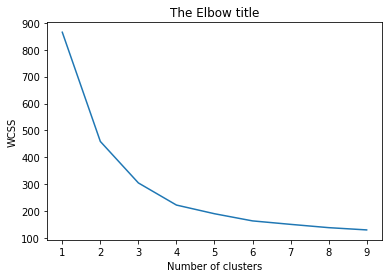

In [85]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [103]:
#run kmeans with no. of clusters you see fit the most

k = 3

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_
df['KMeans ID']

0      0
1      0
2      1
3      1
4      1
      ..
295    1
296    0
297    0
298    0
299    0
Name: KMeans ID, Length: 300, dtype: int32

In [104]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [105]:
df_kmeans

,KMeans ID,texts
0,0,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
1,1,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
2,2,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...


In [106]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [107]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [108]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [109]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [110]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [111]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [125]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน','อยู่','ใน','เช่น','ต่อ','ได้','ที่','ได้','แต่','ค่ะ','ครับ','คับ','และ','นะ','ต่อ','ตอน','จะ','สำหรับ','แล้ว','เรา','คือ','เจอ','กก','แตงโม','คน','ผม','ไหม','ดิชั้น','ชั้น']
screening_words = stopwords + removed_words

new_words = {"สตารบัก"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [126]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [127]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[ชอบ, ทาน, Macchiato, เป็นประจำ, นึง, เด, Arto...","[(ร้านกาแฟ, 25), (กาแฟ, 23), (ทาน, 14), (ชอบ, ..."
1,1,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คว...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 14), (กิน, 13), (อร่อย, 11), (อาห..."
2,2,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า, บ่าย, เย็...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (ทาน, 6), (..."


In [128]:
#show top keywords of each cluster

top_N_words = 20

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ร้านกาแฟ', 25), ('กาแฟ', 23), ('ทาน', 14), ('ชอบ', 10), ('กิน', 10), ('คาเฟ่', 6), ('น', 6), ('แวะ', 6), ('ดี', 6), ('รี่', 5), ('อร่อย', 5), ('กา', 5), ('น่ารัก', 5), ('กร้าน', 5), ('นั่ง', 5), ('สวัสดี', 5), ('รีวิว', 5), ('หา', 5), ('นึง', 4), ('อ', 4)]

Cluster ID : 1

Most common words include : [('ร้านอาหาร', 14), ('กิน', 13), ('อร่อย', 11), ('อาหาร', 10), ('ทาน', 9), ('รีวิว', 7), ('บ้าน', 6), ('ส้มตำ', 6), ('ซอย', 6), ('สาขา', 6), ('เพื่อน', 5), ('ไทย', 5), ('เมนู', 5), ('กาแฟ', 5), ('สวัสดี', 4), ('ถนน', 4), ('ราคา', 4), ('แซ่บ', 4), ('รอบ', 4), ('บอ', 4)]

Cluster ID : 2

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('ทาน', 6), ('เครื่องดื่ม', 4), ('ร้า', 3), ('น้ำ', 3), ('ตั้งอยู่', 3), ('รีวิว', 3), ('ลอง', 3), ('เดิน', 3), ('ปั่น', 3), ('ไต้หวัน', 3), ('แวะ', 2), ('เติม', 2), ('นขา', 2), ('ชาเขียว', 2), ('นิว', 2), ('คุง', 2), ('ขาย', 2)]



**Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [129]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters=10, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [130]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [131]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [132]:
#show top keywords of each cluster

top_N_words = 20

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('อร่อย', 508), ('ทาน', 416), ('รสชาติ', 407), ('ดี', 347), ('กิน', 339), ('กาแฟ', 311), ('เมนู', 309), ('สั่ง', 301), ('อาหาร', 285), ('ราคา', 273), ('(', 270), ('ชา', 262), (')', 250), ('บาท', 242), ('ชอบ', 229), ("','", 215), ('หวาน', 206), ('นั่ง', 201), ('จาน', 196), ('ลอง', 178)]

Cluster ID : 1

Most common words include : [('น้ำ', 8), ('ปั่น', 6), ('เนื้อ', 6), ('เลือก', 4), ('ซื้อ', 4), ('ดื่ม', 4), ('พันธุ์', 3), ('รับประทาน', 3), ('แก้', 3), ('อาหาร', 3), ('ร่างกาย', 3), ('เมล็ด', 2), ('มีรส', 2), ('หวาน', 2), ('เย็น', 2), ('ยังมี', 2), ('วิตามิน', 2), ('สีแดง', 2), ('ผลไม้', 2), ('กระหาย', 2)]

Cluster ID : 2

Most common words include : [('แย่มาก', 3), ('โต๊ะ', 2), ('รอง', 2), ('แก้ว', 2), ("['", 1), ('ดิ', 1), ('ช้ัน', 1), ('ทบ', 1), ('น', 1), ('อาหาร', 1), ('เวลา', 1), ('โมง', 1), ('เย็น', 1), ('แม่ศรี', 1), ('เรือน', 1), ('โฮมโปร', 1), ('แขก', 1), ('พนักงานบริการ', 1), ('เมนู', 1), ('ยืน', 1)]



**Step 4 - result discussion**

Comparing document clustering using K-mean and using Agglomorative Clustering with cosine similarity, K-mean shows more meaningful result. The Elbow plot shows that 4 clusters should be used to perform clustering but the result indicates duplicate word like "ร้านกาแฟ" in 2 different clusters. Also, it seem like there are only 3 clusters, so the number of K was changed to 3. The k-mean clustering result shows that there are 3 types of customers, i.e., customers from coffee shops and cafe, customers from resturants (mostly Somtam resturant), and customers from bubble milk tea shop. 